In [1]:
!nvidia-smi

Mon Dec 16 22:59:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:27:00.0 Off |                   On |
| N/A   56C    P0             78W /  250W |                  N/A   |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

In [2]:
import autosklearn
print(autosklearn.__version__)

0.15.0


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import autosklearn.regression

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [4]:
pd.set_option('display.max_columns', None)

In [29]:
train = pd.read_csv('/home/onyxia/work/Insurance-Premium/train_1.csv')
test = pd.read_csv('/home/onyxia/work/Insurance-Premium/test_1.csv')

In [30]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [31]:
test.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


In [32]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1200000.0,599999.500000,346410.305851,0.000000,299999.750000,599999.500000,899999.250000,1.199999e+06
Age,1181295.0,41.145563,13.539950,18.000000,30.000000,41.000000,53.000000,6.400000e+01
Annual Income,1155051.0,32745.217777,32179.506124,1.000000,8001.000000,23911.000000,44634.000000,1.499970e+05
Number of Dependents,1090328.0,2.009934,1.417338,0.000000,1.000000,2.000000,3.000000,4.000000e+00
Health Score,1125924.0,25.613908,12.203462,2.012237,15.918959,24.578648,34.527209,5.897591e+01
Previous Claims,835971.0,1.002689,0.982840,0.000000,0.000000,1.000000,2.000000,9.000000e+00
Vehicle Age,1199994.0,9.569889,5.776189,0.000000,5.000000,10.000000,15.000000,1.900000e+01
Credit Score,1062118.0,592.924350,149.981945,300.000000,468.000000,595.000000,721.000000,8.490000e+02
Insurance Duration,1199999.0,5.018219,2.594331,1.000000,3.000000,5.000000,7.000000,9.000000e+00
Premium Amount,1200000.0,1102.544822,864.998859,20.000000,514.000000,872.000000,1509.000000,4.999000e+03


In [33]:
target = (set(train.columns) - set(test.columns)).pop()

print(f"Target column: {target}")
print(f"Data type: {train[target].dtype}")

Target column: Premium Amount
Data type: float64


In [34]:
train_info={
    'Data Type': train.dtypes,
    'Missing Values(MV)': train.isnull().sum(),
    'MV percentage(%)' : train.isnull().mean() * 100,
    'Unique Values': train.nunique()
}

train_summary = pd.DataFrame(train_info)
train_summary

,Data Type,Missing Values(MV),MV percentage(%),Unique Values
id,int64,0,0.000000,1200000
Age,float64,18705,1.558750,47
Gender,object,0,0.000000,2
Annual Income,float64,44949,3.745750,88593
Marital Status,object,18529,1.544083,3
Number of Dependents,float64,109672,9.139333,5
Education Level,object,0,0.000000,4
Occupation,object,358075,29.839583,3
Health Score,float64,74076,6.173000,532657
Location,object,0,0.000000,3


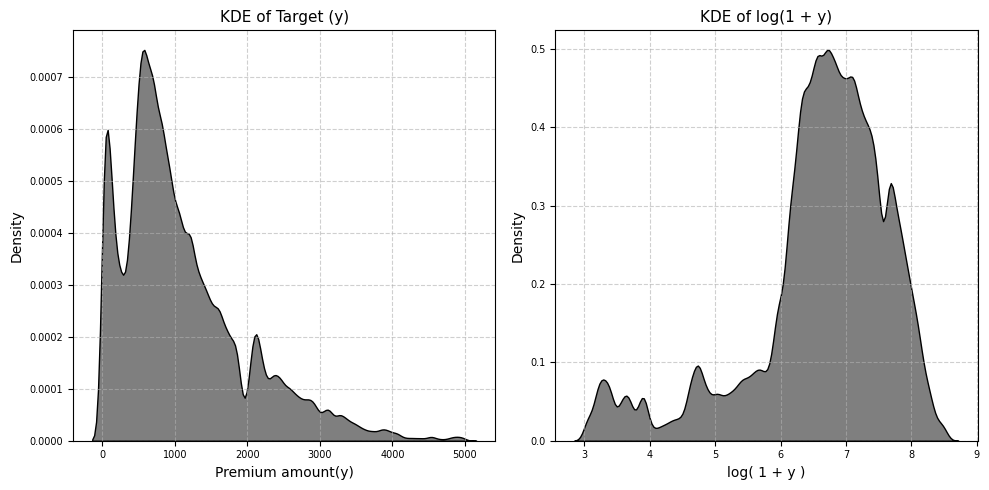

In [35]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(train[target], fill=True, color='black', alpha=0.5)
plt.title('KDE of Target (y)', fontsize=11)
plt.xlabel('Premium amount(y)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.grid(True, linestyle='--', alpha=0.6)


y_train_log = np.log1p(train[target])
plt.subplot(1, 2, 2)
sns.kdeplot(y_train_log, fill=True, color='black', alpha=0.5)
plt.title(f'KDE of log(1 + y)', fontsize=11)
plt.xlabel(f'log( 1 + y )', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### Datetime Transformation

In [36]:
datetime_columns = train.select_dtypes(include=['object']).columns

for col in datetime_columns:
    try:
        # Convert the column to datetime format
        train[col] = pd.to_datetime(train[col], errors='raise')
        test[col] = pd.to_datetime(test[col], errors='raise')
        
        # Convert datetime to epoch time
        train[col] = train[col].astype(np.int64) / 10**9
        test[col] = test[col].astype(np.int64) / 10**9

        print(f"Converted '{col}' to epoch time.")
    except Exception:
        continue

Converted 'Policy Start Date' to epoch time.


In [37]:
train.tail()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
1199995,1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,NaN,5.0,372.0,3.0,1.683127e+09,Poor,No,Daily,Apartment,1303.0
1199996,1199996,54.0,Male,35786.0,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,Comprehensive,NaN,10.0,597.0,4.0,1.662823e+09,Poor,No,Weekly,Apartment,821.0
1199997,1199997,19.0,Male,51884.0,Divorced,0.0,Master's,NaN,14.724469,Suburban,Basic,0.0,19.0,NaN,6.0,1.621956e+09,Good,No,Monthly,Condo,371.0
1199998,1199998,55.0,Male,NaN,Single,1.0,PhD,NaN,18.547381,Suburban,Premium,1.0,7.0,407.0,4.0,1.632065e+09,Poor,No,Daily,Apartment,596.0
1199999,1199999,21.0,Female,NaN,Divorced,0.0,PhD,NaN,10.125323,Rural,Premium,0.0,18.0,502.0,6.0,1.598455e+09,Good,Yes,Monthly,House,2480.0


In [13]:
# num_cols = train.select_dtypes(include=['float64', 'int64']).columns

# plt.figure(figsize=(15, 20))

# for i, col in enumerate(num_cols, 1):
#     plt.subplot(len(num_cols)//3 + 1, 3, i)
#     sns.histplot(train[col], kde=True, bins=30, color='violet', stat='density', linewidth=0)
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Density')
#     plt.xticks(rotation=45)

#     feature_skewness = skew(train[col].dropna())
#     print(f"Skewness of {col}: {feature_skewness:.2f}")

# plt.tight_layout()
# plt.show()

### Missing Value

In [14]:
# # Fill missing values in numeric columns
# numeric_columns = train.select_dtypes(include=['number']).columns
# for col in numeric_columns:
#     if col in test.columns:
#         median_value = train[col].median()  # Calculate the median
#         train[col].fillna(median_value, inplace=True)
#         test[col].fillna(median_value, inplace=True)

# # Fill missing values in object columns
# object_columns = train.select_dtypes(include=['object']).columns
# for col in object_columns:
#     if col in test.columns:
#         train[col].fillna("Unknown", inplace=True)
#         test[col].fillna("Unknown", inplace=True)

In [38]:
train = train.dropna()

In [39]:
train.isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64

### Label Encoding

In [40]:
le = LabelEncoder()
object_columns = train.select_dtypes(include=['object']).columns
for column_name in object_columns:
    train[column_name] = le.fit_transform(train[column_name])    
    # test[column_name] = le.transform(test[column_name])

In [41]:
train.dtypes

id                        int64
Age                     float64
Gender                    int64
Annual Income           float64
Marital Status            int64
Number of Dependents    float64
Education Level           int64
Occupation                int64
Health Score            float64
Location                  int64
Policy Type               int64
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Policy Start Date       float64
Customer Feedback         int64
Smoking Status            int64
Exercise Frequency        int64
Property Type             int64
Premium Amount          float64
dtype: object

In [42]:
train

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,0,10049.0,1,1.0,0,1,22.598761,2,2,2.0,17.0,372.0,5.0,1.703345e+09,2,0,3,2,2869.0
4,4,21.0,1,39651.0,2,1.0,0,1,20.376094,0,2,0.0,8.0,598.0,4.0,1.638372e+09,2,1,3,2,2022.0
7,7,48.0,0,127237.0,0,2.0,1,0,5.769783,1,1,1.0,11.0,398.0,5.0,1.659972e+09,0,0,2,1,111.0
9,9,44.0,1,52447.0,1,2.0,2,0,20.473718,2,1,1.0,9.0,635.0,3.0,1.596382e+09,2,0,0,1,64.0
15,15,18.0,1,6076.0,1,2.0,1,0,7.442964,2,2,1.0,12.0,584.0,5.0,1.602948e+09,1,1,1,0,849.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199982,1199982,51.0,1,6011.0,2,4.0,2,2,41.662597,1,1,1.0,16.0,547.0,9.0,1.667489e+09,0,1,1,2,563.0
1199985,1199985,45.0,1,39724.0,1,0.0,0,0,29.457817,1,0,1.0,13.0,519.0,4.0,1.606663e+09,0,0,1,2,563.0
1199986,1199986,19.0,1,1098.0,0,4.0,1,0,13.097153,1,1,1.0,17.0,551.0,3.0,1.566919e+09,0,0,3,1,2760.0
1199988,1199988,40.0,0,5711.0,0,4.0,2,0,47.096909,0,0,2.0,4.0,710.0,3.0,1.678030e+09,1,1,2,0,1542.0


### Dataset Normalization

In [43]:
# Select numerical columns
numerical_columns = train.select_dtypes(include=['float64']).columns
numerical_columns = numerical_columns[numerical_columns != target]

# Applying Normalization
scaler = StandardScaler()
train[numerical_columns] = scaler.fit_transform(train[numerical_columns])
test[numerical_columns] = scaler.transform(test[numerical_columns])

In [ ]:
train

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,-1.636124,0,-0.711267,1,-0.716429,0,1,-0.244490,2,2,1.026164,1.288244,-1.483969,-0.007840,1.299320,2,0,3,2,2869.0
4,4,-1.488322,1,0.203214,2,-0.716429,0,1,-0.426765,0,2,-1.018492,-0.270467,0.026651,-0.392971,-0.141289,2,1,3,2,2022.0
7,7,0.507006,0,2.908968,0,-0.009953,1,0,-1.624586,1,1,0.003836,0.249103,-1.310180,-0.007840,0.337637,0,0,2,1,111.0
9,9,0.211402,1,0.598515,1,-0.009953,2,0,-0.418759,2,1,0.003836,-0.097277,0.273965,-0.778101,-1.072320,2,0,0,1,64.0
15,15,-1.710025,1,-0.834003,1,-0.009953,1,0,-1.487373,2,2,0.003836,0.422293,-0.066927,-0.007840,-0.926727,1,1,1,0,849.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199982,1199982,0.728709,1,-0.836011,2,1.402999,2,2,1.318879,1,1,0.003836,1.115054,-0.314241,1.532683,0.504303,0,1,1,2,563.0
1199985,1199985,0.285303,1,0.205469,1,-1.422905,0,0,0.318001,1,0,0.003836,0.595483,-0.501397,-0.392971,-0.844351,0,0,1,2,563.0
1199986,1199986,-1.636124,1,-0.987786,0,1.402999,1,0,-1.023689,1,1,0.003836,1.288244,-0.287504,-0.778101,-1.725574,0,0,3,1,2760.0
1199988,1199988,-0.084202,0,-0.845278,0,1.402999,2,0,1.764531,0,0,1.026164,-0.963228,0.775277,-0.778101,0.738019,1,1,2,0,1542.0


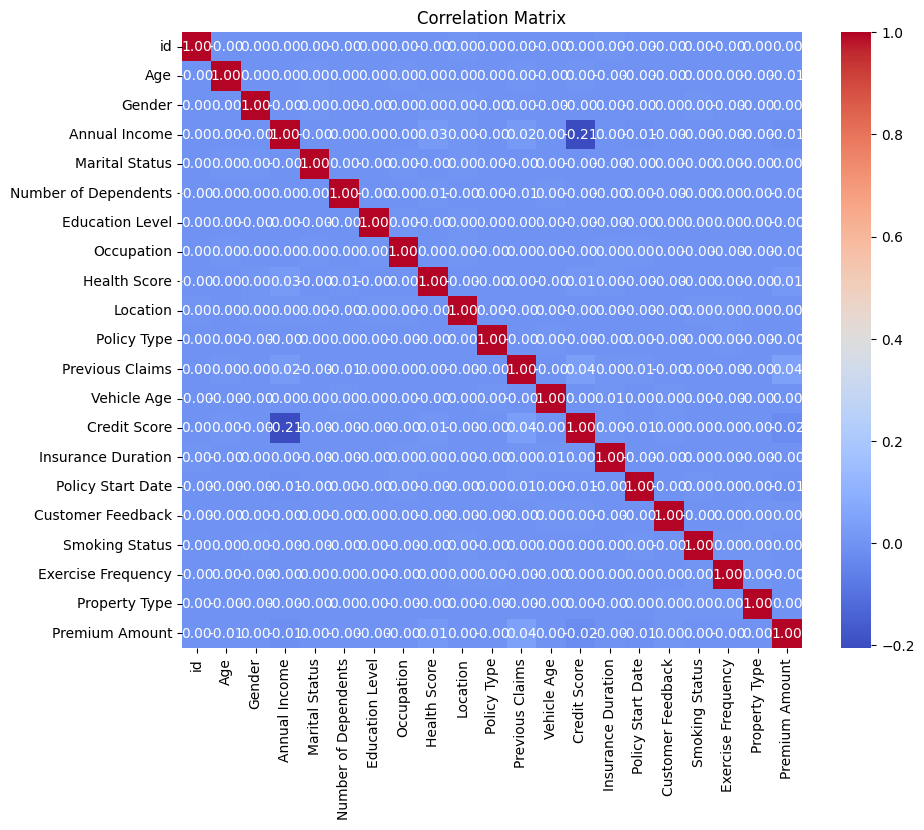

In [45]:
corr_matrix = train.corr()

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [46]:
print(corr_matrix['Premium Amount'].sort_values(ascending=False))

Premium Amount          1.000000
Previous Claims         0.043884
Health Score            0.013895
Customer Feedback       0.003527
Vehicle Age             0.001779
Marital Status          0.001578
Gender                  0.001188
Location                0.000812
Smoking Status          0.000702
id                      0.000606
Property Type           0.000308
Insurance Duration     -0.000219
Exercise Frequency     -0.000793
Number of Dependents   -0.000911
Policy Type            -0.001389
Education Level        -0.001571
Occupation             -0.002341
Age                    -0.005098
Policy Start Date      -0.010748
Annual Income          -0.013108
Credit Score           -0.022819
Name: Premium Amount, dtype: float64


### Feature Engineering

In [47]:
# Prepare training data
X_train = train.drop([target], axis=1)
y_train = train[target]
y_train_log = np.log1p(y_train)

display(X_train.dtypes, y_train.dtypes, y_train_log.dtypes)

id                        int64
Age                     float64
Gender                    int64
Annual Income           float64
Marital Status            int64
Number of Dependents    float64
Education Level           int64
Occupation                int64
Health Score            float64
Location                  int64
Policy Type               int64
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Policy Start Date       float64
Customer Feedback         int64
Smoking Status            int64
Exercise Frequency        int64
Property Type             int64
dtype: object

dtype('float64')

dtype('float64')

In [48]:
X_train

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,0,-1.636124,0,-0.711267,1,-0.716429,0,1,-0.244490,2,2,1.026164,1.288244,-1.483969,-0.007840,1.299320,2,0,3,2
4,4,-1.488322,1,0.203214,2,-0.716429,0,1,-0.426765,0,2,-1.018492,-0.270467,0.026651,-0.392971,-0.141289,2,1,3,2
7,7,0.507006,0,2.908968,0,-0.009953,1,0,-1.624586,1,1,0.003836,0.249103,-1.310180,-0.007840,0.337637,0,0,2,1
9,9,0.211402,1,0.598515,1,-0.009953,2,0,-0.418759,2,1,0.003836,-0.097277,0.273965,-0.778101,-1.072320,2,0,0,1
15,15,-1.710025,1,-0.834003,1,-0.009953,1,0,-1.487373,2,2,0.003836,0.422293,-0.066927,-0.007840,-0.926727,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199982,1199982,0.728709,1,-0.836011,2,1.402999,2,2,1.318879,1,1,0.003836,1.115054,-0.314241,1.532683,0.504303,0,1,1,2
1199985,1199985,0.285303,1,0.205469,1,-1.422905,0,0,0.318001,1,0,0.003836,0.595483,-0.501397,-0.392971,-0.844351,0,0,1,2
1199986,1199986,-1.636124,1,-0.987786,0,1.402999,1,0,-1.023689,1,1,0.003836,1.288244,-0.287504,-0.778101,-1.725574,0,0,3,1
1199988,1199988,-0.084202,0,-0.845278,0,1.402999,2,0,1.764531,0,0,1.026164,-0.963228,0.775277,-0.778101,0.738019,1,1,2,0


In [49]:
y_train

0          2869.0
4          2022.0
7           111.0
9            64.0
15          849.0
            ...  
1199982     563.0
1199985     563.0
1199986    2760.0
1199988    1542.0
1199990     231.0
Name: Premium Amount, Length: 384004, dtype: float64

In [50]:
y_train_log

0          7.962067
4          7.612337
7          4.718499
9          4.174387
15         6.745236
             ...   
1199982    6.335054
1199985    6.335054
1199986    7.923348
1199988    7.341484
1199990    5.446737
Name: Premium Amount, Length: 384004, dtype: float64

In [51]:
from sklearn.ensemble import RandomForestRegressor

# Initialize a Random Forest Regressor
model = RandomForestRegressor()

# Fit the model
model.fit(X_train, y_train_log)

RandomForestRegressor()

In [54]:
importances = model.feature_importances_
features = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
3,Annual Income,0.125825
8,Health Score,0.118311
13,Credit Score,0.117334
15,Policy Start Date,0.112470
0,id,0.107020
1,Age,0.075566
12,Vehicle Age,0.060558
14,Insurance Duration,0.043356
5,Number of Dependents,0.029922
11,Previous Claims,0.029361


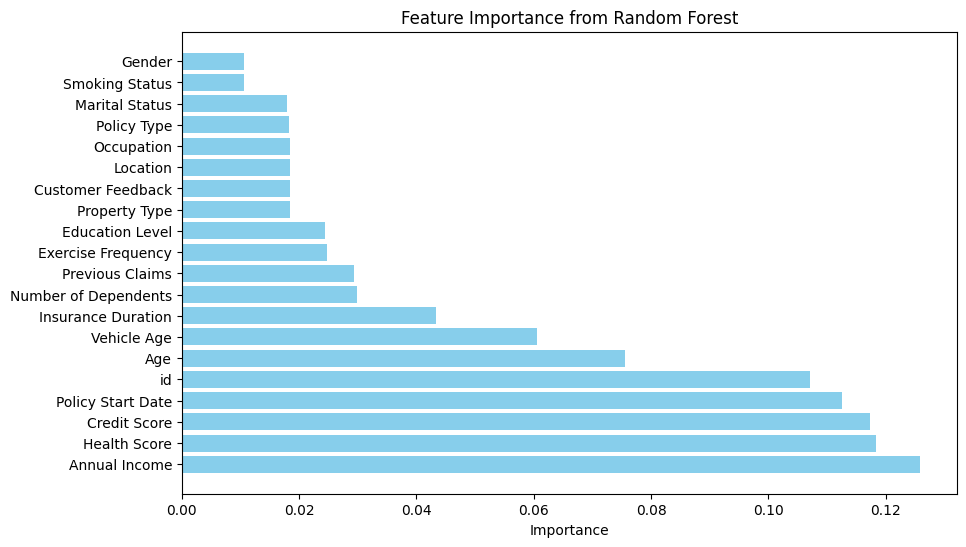

In [55]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

In [56]:
selected_features = feature_importance_df['Feature'][:10]
X_train_selected = X_train[selected_features]
X_train_selected

,Annual Income,Health Score,Credit Score,Policy Start Date,id,Age,Vehicle Age,Insurance Duration,Number of Dependents,Previous Claims
0,-0.711267,-0.244490,-1.483969,1.299320,0,-1.636124,1.288244,-0.007840,-0.716429,1.026164
4,0.203214,-0.426765,0.026651,-0.141289,4,-1.488322,-0.270467,-0.392971,-0.716429,-1.018492
7,2.908968,-1.624586,-1.310180,0.337637,7,0.507006,0.249103,-0.007840,-0.009953,0.003836
9,0.598515,-0.418759,0.273965,-1.072320,9,0.211402,-0.097277,-0.778101,-0.009953,0.003836
15,-0.834003,-1.487373,-0.066927,-0.926727,15,-1.710025,0.422293,-0.007840,-0.009953,0.003836
...,...,...,...,...,...,...,...,...,...,...
1199982,-0.836011,1.318879,-0.314241,0.504303,1199982,0.728709,1.115054,1.532683,1.402999,0.003836
1199985,0.205469,0.318001,-0.501397,-0.844351,1199985,0.285303,0.595483,-0.392971,-1.422905,0.003836
1199986,-0.987786,-1.023689,-0.287504,-1.725574,1199986,-1.636124,1.288244,-0.778101,1.402999,0.003836
1199988,-0.845278,1.764531,0.775277,0.738019,1199988,-0.084202,-0.963228,-0.778101,1.402999,1.026164


## Model Training

In [57]:
import time

### I will use 10% of data to test the automl

In [58]:
# X_train_sample = X_train_selected.sample(frac=0.1, random_state=42)
# y_train_sample = y_train_log.sample(frac=0.1, random_state=42)
# X_train_sample

In [59]:
# Initialize Auto-sklearn regressor
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=1800,  # 30 minutes
    per_run_time_limit=180,        # Time limit for each individual model
    n_jobs=-1  
)

In [60]:
start_time = time.time()
automl.fit(X_train_selected, y_train_log)
print(f"Auto-sklearn training time: {time.time() - start_time:.2f} seconds")

[ERROR] [2024-12-16 23:15:59,753:Client-AutoML(1):b315f873-bc03-11ef-b94e-ee95b585dee8] (" Dummy prediction failed with run state StatusType.MEMOUT and additional output: {'error': 'Memout (used more than 3072 MB).', 'configuration_origin': 'DUMMY'}.",)
[ERROR] [2024-12-16 23:15:59,753:Client-AutoML(1):b315f873-bc03-11ef-b94e-ee95b585dee8] (" Dummy prediction failed with run state StatusType.MEMOUT and additional output: {'error': 'Memout (used more than 3072 MB).', 'configuration_origin': 'DUMMY'}.",)
Traceback (most recent call last):
  File "/opt/conda/envs/autosklearn-env/lib/python3.9/site-packages/autosklearn/automl.py", line 765, in fit
    self._do_dummy_prediction()
  File "/opt/conda/envs/autosklearn-env/lib/python3.9/site-packages/autosklearn/automl.py", line 489, in _do_dummy_prediction
    raise ValueError(msg)
ValueError: (" Dummy prediction failed with run state StatusType.MEMOUT and additional output: {'error': 'Memout (used more than 3072 MB).', 'configuration_origin':

ValueError: (" Dummy prediction failed with run state StatusType.MEMOUT and additional output: {'error': 'Memout (used more than 3072 MB).', 'configuration_origin': 'DUMMY'}.",)